In [1]:
using Plots #Librería para realizar gráficos
using Interpolations #Librería para hacer interpolación
using Images #Librería para cargar imágenes en el código

# Introducción al modelo TOMGRO

El modelo TOMGRO describe el desarrollo fenológico y el incremento en el peso seco de diferentes órganos de la planta desde el momento de la plantación hasta la finalización de la cosecha, bajo la influencia de variables como la radiación solar, la temperatura del entorno y la concentración de dióxido de carbono. En este cuaderno se implementa una versión del modelo que será explicada a continuación. También, se realizará una implementación y descripción exhaustiva del código con el que se ejecuta el modelo.

# Datos iniciales

Los datos iniciales para el funcionamiento del modelo se organizan en una matriz de seis columnas; esta información se encuentra guardada en el archivo "C99AF1B.TXT". Las columnas respresentan lo siguiente:
- Día
- Hora
- Intensidad de la radiación solar total (solrad)($W\cdot m^{-2}$)
- Temperatura (TMPA)
- Presión de vapor de aire (VPD)($kPa$)
- Concentración de $CO_2$ en el aire (CO2L) ($gCO_2 \cdot m^{-2}\cdot h^{-1}$)

Consta de un total de $4800$ datos en cada columna.

In [2]:
TableC99AF1B = [split(fila, " ") for fila in split(read("C99AF1B.TXT", String), "\r\n")]
DatI = zeros(4800,6)
for i=1:4800
	for j=1:6
		DatI[i,j]=parse(Float64,TableC99AF1B[i,:][1][j])
	end
end	
DatI

4800×6 Matrix{Float64}:
  25.0   1.0    0.0  10.25  0.002  350.0
  25.0   2.0    0.0  10.25  0.0    350.0
  25.0   3.0    0.0  10.48  0.0    350.0
  25.0   4.0    0.0   9.27  0.01   350.0
  25.0   5.0    0.0   8.73  0.047  350.0
  25.0   6.0    4.0   9.77  0.03   426.0
  25.0   7.0    8.0  10.62  0.018  380.0
  25.0   8.0   43.0  13.33  0.081  347.0
  25.0   9.0   87.0  15.03  0.252  324.0
  25.0  10.0  187.0  18.87  0.838  310.0
  25.0  11.0  290.0  20.68  0.456  303.0
  25.0  12.0  298.0  22.42  0.461  300.0
  25.0  13.0  157.0  21.27  1.556  301.0
   ⋮                                 ⋮
 224.0  13.0  278.0  26.95  2.252  301.0
 224.0  14.0  261.0  26.99  2.287  302.0
 224.0  15.0  191.0  23.79  1.663  303.0
 224.0  16.0  196.0  23.63  1.692  301.0
 224.0  17.0   86.0  23.6   1.502  295.0
 224.0  18.0   36.0  22.26  1.151  295.0
 224.0  19.0   20.0  19.84  0.773  322.0
 224.0  20.0   10.0  18.86  0.713  350.0
 224.0  21.0    3.0  18.77  0.692  350.0
 224.0  22.0    0.0  18.72  0.766  

Los datos se extienden en el tiempo a lo largo de $200$ días, que corresponderían a un solo periodo de cosecha. Para cada uno de estos días se tienen datos cada hora de valores de variables climáticas alrededor de las plantas de tomate. A continuación presentamos la información de intensidad de radiación solar, temperatura, presión de vapor de aire y concentración de $CO_2$ vista en las primeras $48$ horas que se consideran en el periodo de tiempo. Nótese que todos los datos a pesar de no repetirse periódicamente, sí hay patrones que se repiten todos los días a ciertas horas específicas de cada día.

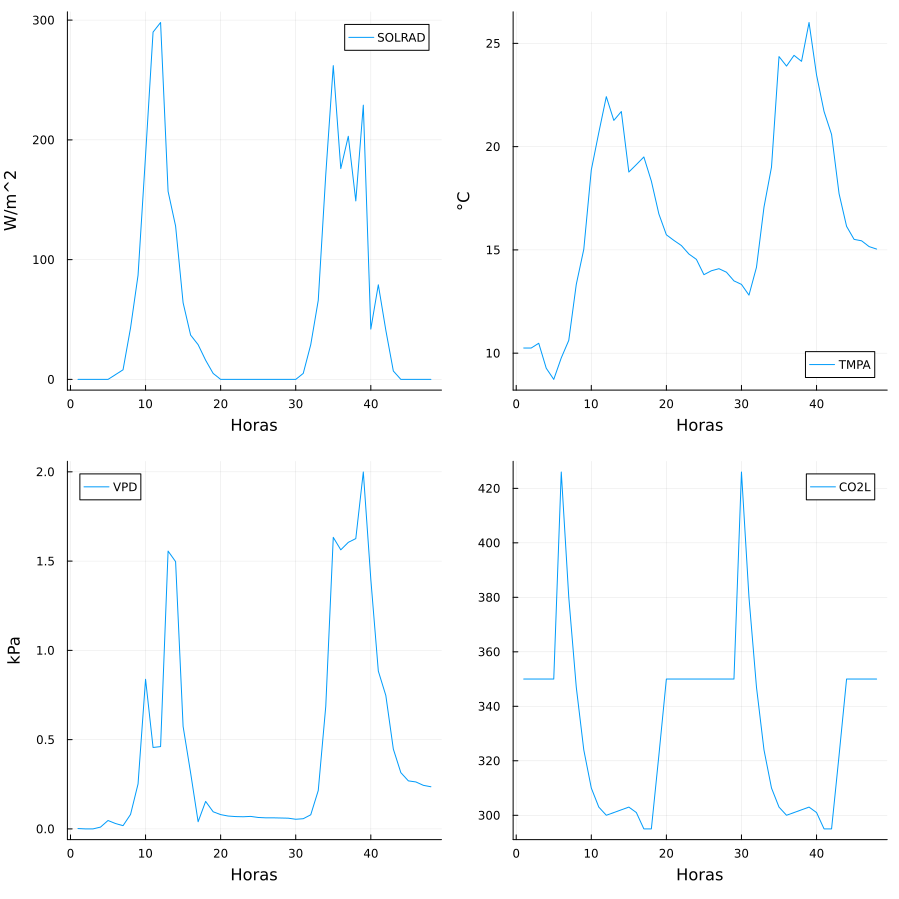

In [3]:
plotA3 = plot(DatI[1:48,3],label="SOLRAD",ylabel="W/m^2",xlabel="Horas")
plotA4 = plot(DatI[1:48,4],label="TMPA",ylabel="°C",xlabel="Horas")
plotA5 = plot(DatI[1:48,5],label="VPD",ylabel="kPa",xlabel="Horas")
plotA6 = plot(DatI[1:48,6],label="CO2L",ylabel="",xlabel="Horas")
plot(plotA3,plotA4,plotA5,plotA6, layout=(2,2),size=(900,900))

# Variables y parámetros iniciales

En esta sección se inicializan los parámetros y las variables necesarios para el funcionamiento de modelo. El valor asignado tanto de variables como de parámetros se toman de (). Se presenta una descripción de cada elemento que aparece en el código.

## Parámetros

-  `XK`es el coeficiente de extinción de la luz de la cubierta (sin dimensión). Este parámetro se usa en el *cálculo de la fotosíntesis gruesa*, más específicamente en el modelo de Acock ().
-  `XM`
-  `VPDL`
-  `QE`
-  `TAU1`
-  `TPL`
-  `EPS`
-  `GREF`
-  `FPNPT`
-  `ABORMX`
-  `Q10`
-  `RMRL`
-  `RMRF`
-  `FTRUSN`
-  `SLAMX`
-  `FRLG`
-  `FRPT`
-  `FRST`
-  `BOX`
-  `POL`
-  `POF`
-  `NBFPT`
-  `PGRED`
-  `TMPG`
-  `GENTEM`
-  `XTEM`
-  `GENRAT`
-  `XGEN`
-  `RDVLVT`
-  `XLV`
-  `RDVFRT`
-  `XFR`
-  `PROOT`
-  `XROOT`
-  `PLETEM`
-  `TEMPLE`
-  `SLAM`
-  `TEMSLA`

In [4]:
# Parámetros

XK = 0.58
XM = 0.091
CK = -0.8
VPDL = 3.0
QE = 0.0645
TAU1 = 0.0693
TPL = 0.336
EPS = 1e-12
GREF = 0.75
FPNPT = 1.23
ABORMX = 0.73
Q10 = 1.4
RMRL = 0.015
RMRF = 0.01
FTRUSN = 9.64
SLAMX = 0.06
FRLG = 9.33
FRPT = 0.277
FRST = 0.418
	
BOX = [0.0, 5.0, 15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0, 95.0, 100.0]
POL = [0.0, 0.00141, 0.00345, 0.00505, 0.00536, 0.00465, 0.00357, 0.00253, 0.00171, 0.00112, 0.00072, 0.0]
POF = [0.0, 0.022, 0.116, 0.296, 0.476, 0.539, 0.508, 0.420, 0.319, 0.229, 0.159, 0.0]

NBFPT = 5.0*ones(100)
NBFPT[1] = 4.0

PGRED = [0.0, 0.67, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
TMPG = [0.0, 9.0, 12.0, 15.0, 21.0, 28.0, 35.0, 50.0]
GENTEM = [0.0, 0.0, 0.53, 1.0, 0.0, 0.0]
XTEM = [0.0, 5.0, 10.0, 28.0, 50.0, 51.0]
GENRAT = [0.69, 0.69, 0.60, 0.50, 0.41, 0.32, 0.32, 0.32]
XGEN = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0]
RDVLVT = [0.0, 0.0, 0.0085, 0.0288, 0.0288, 0.0, 0.0, 0.0, 0.0]
XLV = [0.0, 5.0, 10.0, 28.0, 35.0, 50.0, 51.0, 52.0, 53.0]
RDVFRT = [0.0, 0.0, 0.00893, 0.0232, 0.0232, 0.0, 0.0, 0.0, 0.0]
XFR = [0.0, 5.0, 10.0, 28.0, 35.0, 50.0, 51.0, 52.0, 53.0]
PROOT = [0.2, 0.1, 0.07, 0.07, 0.07, 0.07]
XROOT = [0.0, 20.0, 30.0, 45.0, 50.0, 60.0]
PLETEM = [0.0, 0.0, 0.8, 1.0, 1.0, 0.0]
TEMPLE = [0.0, 12.0, 17.0, 28.0, 35.0, 50.0]
SLAM = [0.0, 0.0120, 0.0275, 0.0520, 0.0520, 0.0520]
TEMSLA = [12.0, 15.6, 20.4, 28.0, 35.0, 50.0]

6-element Vector{Float64}:
 12.0
 15.6
 20.4
 28.0
 35.0
 50.0

## Valores iniciales de variables de estado y auxiliares

- `NSTART`
- `NDAYS`
- `DELT`
- `NFAST`
- `INTOUT`
- `TRGH`
- `PLM2`
- `PLSTNI`
- `WLVSI`
- `PLARI`
- `WSTMI` 

In [5]:
#Valores iniciales de variables de estado y auxiliares

NSTART = 25
NDAYS = 140
DELT = 1.0
NFAST = 24
INTOUT = 1
TRGH = 0.473
PLM2 = 2.5
PLSTNI = 18.77
WLVSI = 8.66
PLARI = 0.187
WSTMI = 3.56

3.56

## Inicialización de variables de estado y auxiliares

- `DTFAST`
- `TABF`
- `TNSF`
- `TNF`
- `DWL`
- `XLA`
- `DWS`
- `AGLS`
- `ABOR`
- `XNFT`
- `DWTR`
- `PLE`
- `PGL`
- `PGS`
- `ABNF`
- `NSF`
- `RCNF`
- `DWF`
- `AGF`
- `PGF`
- `PLSTN`
- `PLAR`
- `PLAR2`
- `CPOOL`
- `TDML`
- `TDML2`
- `TDMS`
- `TDMF`
- `DMGF`
- `DMGL`
- `RCDRW`
- `SOSIR`
- `GRESP`
- `TRESP`

In [6]:
# Inicialización de variables de estado y auxiliares

DTFAST = 1.0 / NFAST
# número de frutas "abortadas", ajuste de frutas y su cantidad total	
TABF = 0
TNSF = 0
TNF = 0


DWL = zeros(100)
XLA = zeros(100)
DWS = zeros(100)
AGLS = zeros(100)
ABOR = zeros(100)
XNFT = zeros(100)
DWTR = zeros(100)
PLE = zeros(100)
PGL = zeros(100)
PGS = zeros(100)
ABNF = zeros(100)
NSF = zeros(100)
	

RCNF = zeros(100)

# Todas las variables en la primera etapa de siembra (primer florecimiento de racimo) PRIMERA SECCIÓN
DWL[1] = WLVSI * 0.83
AGLS[1] = 1.0
DWS[1] = WSTMI * 0.93
DWTR[1] = 0
XLA[1] = PLARI * 0.85
ABOR[1] = 0
XNFT[1] = 0
DWTR[1] = 0
# Todas las variables en la primera etapa de siembra (segundo florecimiento de racimo) SEGUNDA SECCIÓN
DWL[2] = WLVSI * 0.17
AGLS[2] = 0.9
DWS[2] = WSTMI * 0.07
DWTR[2] = 0.0
XLA[2] = PLARI * 0.15
ABOR[2] = 0
XNFT[2] = 0
DWTR[2] = 0
# La edad del órgano en la fecha inicial es muy importante para el peso final de los primeros órganos
DWF = zeros(100, 7)
AGF = zeros(100, 7)
PGF = zeros(100, 7)


# Establecer las condiciones iniciales por planta
PLSTN = PLSTNI
PLAR = PLARI
PLAR2 = PLARI
# CPOOL se supone que empieza en un 5% del peso seco de las hojas 
CPOOL = 0.05 * WLVSI
TDML = WLVSI
TDML2 = WLVSI
TDMS = WSTMI
TDMF = 0
DMGF = 0
DMGL = WLVSI

RCDRW = 0.0
SOSIR = 0.0
GRESP = 0.0
TRESP = 0.0

0.0

# Código de modelo TOMGRO - Versión 2

En esta sección se presenta el código que ejecuta el modelo TOMGRO propuesto en (). El modelo se ejecuta en dos ciclos representado por un `for`: ciclo diario y ciclo horario. Para ejecutar el modelo es necesario cargar los datos de clima y también haber inicializado todas las variables y todos los parámetros.

In [7]:
# Cargar datos de clima
RefIntClim = DatI
# Crear la matriz de resultados
results = zeros(NDAYS, 33);

In [8]:
# Ciclo diario
for JDAY in 1:NDAYS
    TIME = (JDAY - 1) * DELT
    DATE = mod(TIME + NSTART, 365)

    # Inicializar variables que se acumulan a lo largo del día
    GP = 0
    TEMFAC = 0
    RMAINT = 0
    RDVLV = 0
    RDVFR = 0
    TEMEXP = 0
    SLAMIN = 0
    
    #************************************************************************************************************
    #************************************************************************************************************
    # Ciclo horario
    for JF in 1:NFAST
        # TFAST es la hora del día (h)
        TFAST = (JF - 1) * 24 / NFAST

        # Insertar datos horarios del clima
        d = findall(x -> x[1] == DATE && x[2] == (TFAST + 1), eachrow(RefIntClim))
        if length(d) > 1
            println("more than 1 found!!")
        end
        if isempty(d)
            println("invalid index of climate data")
        end

        d = d[1]

        
        JUL = RefIntClim[d, 1]
        IHE = RefIntClim[d, 2]
        solrad = RefIntClim[d, 3]
        TMPA = RefIntClim[d, 4]
        VPD = RefIntClim[d, 5]
        CO2L = RefIntClim[d, 6]
        PAR = solrad * TRGH
        PPFD = PAR * 4.57
        #************************************************************************************************************
        # Cálculo de la tasa de desarrollo 
        TEMFCF = LinearInterpolation(XTEM, GENTEM).(TMPA)
        TEMEXP1 = LinearInterpolation(TEMPLE, PLETEM).(TMPA)
        SLAMIN1 = LinearInterpolation(TEMSLA, SLAM,extrapolation_bc=Line()).(RefIntClim[d, 4])
        RDVLVF = LinearInterpolation(XLV, RDVLVT).(TMPA)
        RDVFRF = LinearInterpolation(XFR, RDVFRT).(TMPA)

        #************************************************************************************************************
        # Cálculo de la fotosíntesis gruesa
        GPF = 0
        # Efecto del CO2 en Pmax
        TAU2 = 0.03
        PMAX = TAU1 * CO2L
        if CO2L > 1500
            PMAX = (TAU1 * 1500) + (TAU2 * (CO2L - 1500))
        end
        PMAX *= LinearInterpolation(TMPG,PGRED)(TMPA[1])

        if PPFD >= 0.001
            if VPD >= VPDL
                # Reducción de Pmax por VPD
                PMAX *= exp(CK * (VPD - VPDL))
            end
            # Modelo de Acock
            TOP = (1 - XM) * PMAX + QE * XK * PPFD
            BOT = (1 - XM) * PMAX + QE * XK * PPFD * exp(-XK * PLAR2 * PLM2)
            GPF = (PMAX / XK) * log(TOP / BOT)
            
            GPF *= 0.682  # conversion desde CO2 a CH2O (30/44 = 0.682)
            GPF *= 3.8016 / PLM2  # conversion de GPF desde M/m2 a g/m2-día
        end

        #************************************************************************************************************
        # Cálculo de la respiración de mantenimiento
        RMAINTF = (RMRL * (TDML2 + TDMS) + RMRF * DMGF) * (Q10^(0.1 * TMPA - 2.0))

        #************************************************************************************************************
        # Integración de las variables en 24 horas
        TEMFAC += TEMFCF * DTFAST
        TEMEXP += TEMEXP1 * DTFAST
        SLAMIN += SLAMIN1 * DTFAST
        RMAINT += RMAINTF * DTFAST
        RDVLV += RDVLVF * DTFAST
        RDVFR += RDVFRF * DTFAST
        GP += GPF * DTFAST
    end 
    #Finalización del ciclo horario
    #************************************************************************************************************
    #************************************************************************************************************



    
    #************************************************************************************************************
    # Desarrollo y fuerza de hundimiento
    
    # Número de nodo
    GENR = TEMFAC*LinearInterpolation(XGEN, GENRAT,extrapolation_bc=Line()).(PLSTN)
    PLSTN += GENR

    # Número de racimo
    NBRU = floor((PLSTN - FTRUSN + (1 + TPL) / TPL) * TPL / (1 + TPL))
    NBRU = max(0, NBRU)

    # Número de racimo produciendo frutas
    NBRUP = floor((PLSTN - FTRUSN - FRLG + (1 + TPL) / TPL) * TPL / (1 + TPL))
    NBRUP = max(0, NBRUP)

    # Número de hojas
    NBLV = floor(PLSTN) - NBRU

    # Número de frutas (díametro > 20mm) en cada racimo
    # Nota: FPN es ahora la razón de iniciación de fruta en un racimo por nodo de iniciación
    TRCNF = 0

    if NBRUP == 0
        NBRUP_length = -1
    else
        NBRUP_length = 1:NBRUP
    end
    
    for I in NBRUP_length
        I = Int(I)
        XX = XNFT[I]
        # FPN ahora es reemplazado por FPNPT = 0.8
        XNFT[I] = min(NBFPT[I], XNFT[I] + GENR * FPNPT)
        RCNF[I] = XNFT[I] - XX
        TRCNF += RCNF[I]
        # rncf(i) y trcnf son utilizados en el ajuste de fruta
    end
    TNF += TRCNF

    #************************************************************************************************************
    # Envejecimiento y fuerza de hundimiento (determinado para hojas, tallos y para cada fruta por cada unidad reproductiva)
    PTNLVS = 0
    PTNSTM = 0
    PTNFRT = 0

    # Hojas y tallos
    # nuevas hojas empiezan a envejecer cuando un nuevo racimo aparece (2 hojas abajo y 1 hoja arriba)
    for I in 1:NBRU
        I = Int(I)
        if AGLS[I] == -EPS
            PLE[I] = 0
            PGL[I] = 0
            PGS[I] = 0
        else
            # cuando se poda la hoja, no se asigna más biomasa ni a las hojas ni a los tallos de la misma unidad reproductiva
            AGLS[I] = min(1, AGLS[I] + RDVLV)
            XBOX = 100 * AGLS[I]
            # PLE(I) es el radio de expansión de hojas potencial
            # la primer unidad reproductiva tiene FTRUSN hojas, otras (1 .+ TPL)/TPL
            # 5/10/95:  remplazo de (1 .+ TPL)/TPL por 1/TPL
            if I == 1
                PLE[I] = TEMFAC * max(0, LinearInterpolation(BOX, POL)(XBOX)) * FTRUSN
            elseif I < 3
                PLE[I] = TEMFAC * max(0, LinearInterpolation(BOX, POL)(XBOX)) / TPL
            else
                PLE[I] = TEMEXP * max(0, LinearInterpolation(BOX, POL)(XBOX)) / TPL
            end
            PGL[I] = PLE[I] * (1 + FRPT) / SLAMIN
            PGS[I] = PGL[I] * FRST
        end
        PTNLVS += PGL[I]
        PTNSTM += PGS[I]
    end  # final ciclo

    # Fruta
    for I in 1:NBRU
        I = Int(I)
        for J in 1:floor(XNFT[I])
            J = Int(J)
            AGF[I, J] = min(1, AGF[I, J] + RDVFR)
            XBOX = 100 * AGF[I, J]
            if length(DWF[I, J]) == 0
                PGF[I, J] = 0
            else
                if DWF[I, J] < 0
                    PGF[I, J] = 0
                else
                    PGF[I, J] = TEMFAC * max(0, LinearInterpolation(BOX, POF)(XBOX))
                    PTNFRT += PGF[I, J]
                end
            end
        end
    end

    # Demanda de hundimiento total
    PNGP = PTNLVS + PTNSTM + PTNFRT
    #************************************************************************************************************
    #************************************************************************************************************

    # Producción diaria de biomasa
    
    RCDRW = GREF * (GP + CPOOL - RMAINT)
    if RCDRW < 0
        RCDRW = 0
        RMAINT = GP + CPOOL
    end
    RCDRW *= 1 .- LinearInterpolation(XROOT, PROOT,extrapolation_bc=Line()).(PLSTN)

    # Cálculo de la razón entre oferta y demanda
    SOSIR = min(1, RCDRW / (PNGP + EPS))

    # Respiración de crecimiento diaria
    GRESP = ((PNGP * SOSIR) / GREF) * (1 - GREF * 1.125)
    # 1.125 es (30/12)*0.45 para convertir GREF desde gDM/gCH2O a gCH2O/gCH2O 
    
    # Respiración diaria total
    TRESP = RMAINT + GRESP

    #************************************************************************************************************
    #************************************************************************************************************
    
    # Ajuste de fruta
    
    TABNF = 0
    if TDMF < EPS
        dummy = 0
    else
        FABOR = min(1, (0.67 - ABORMX * SOSIR))
        FABOR = max(0, FABOR)
        TABNF = FABOR * TRCNF
    end

    TABF += TABNF
    TNSF = TNF - TABF

    # Ubicación de las frutas "abortadas": posición distal
    B = 0
    for I in 1:NBRUP
        I = Int(I)
        # Si no hay nuevos frutos, o hay menos de dos frutos en el racimo I o no hay más aborto de frutos
        if RCNF[I] == 0 || XNFT[I] <= 2 || B >= TABNF
            dummy = 0
        else
            ABNF[I] = min(4, RCNF[I], TABNF - B, XNFT[I] - 2 - ABOR[I])
            ABNF[I] = max(0, ABNF[I])
            B += ABNF[I]
            ABOR[I] += ABNF[I]
            NSF[I] = floor(XNFT[I] - ABOR[I])
            # Nótese que esto conduce a 2 frutos abortados para ABOR = 1.1
            
            if ABOR[I] < 1
                dummy = 0
            else
                for J in NSF[I] + 1:floor(XNFT[I])
                    J = Int(J)
                    DWF[I, J] = -EPS
                end
            end
        end
    end

    #************************************************************************************************************
    #************************************************************************************************************

    # Particionamiento de materia seca

    
    ASCSP = 0
    TDML = 0
    TDML2 = 0
    DMGL = 0
    TDMS = 0
    TDMF = 0
    DMGF = 0
    TNMF = 0
    DMMF = 0
    PLAR = 0
    PLAR2 = 0

    # Peso seco de hojas
    for I in 1:NBRU
        I = Int(I)
        J = I + 1
        ASC = min(PGL[I], PGL[I] * SOSIR)
        ASCSP += ASC
        DWL[I] += ASC

        # Peso seco de hojas en crecimiento
        if AGLS[I] < 1
            DMGL += DWL[I]
        end

        # Ahora la expansión del área de las hojas es potencial o está limitada por un SLA máximo
        # Está disponible para cada unidad
        XLA[I] += min(PLE[I], (ASC * SLAMX / (1 + FRPT)))
        TDML += DWL[I]
        
        # Área total de hojas
        PLAR += XLA[I]
        # total menos hojas podadas (hojas podadas al cosechar el racimo)
        if AGLS[I] > 0
            PLAR2 += XLA[I]
            TDML2 += DWL[I]
        end

        #  cuando se cosecha el racimo, también se poda la mitad de las hojas superiores
        if AGLS[I] < 0
            if AGLS[J] > 0
                PLAR2 -= XLA[J] + XLA[J]
                TDML2 -= DWL[J] + DWL[J]
            end
        end
    end

    # Peso seco de hojas
    for I in 1:NBRU + 1
        I = Int(I)
        ASC = min(PGS[I], PGS[I] * SOSIR)
        ASCSP += ASC
        DWS[I] += ASC
        TDMS += DWS[I]
    end

    # Peso seco de las frutas
    TDMF = 0
    ASC = 0
    for I in 1:NBRU
        I = Int(I)
        DWTR[I] = 0
        NFT = floor(XNFT[I])
        for J in 1:NFT
            J = Int(J)
            # Para fruta "abortada", DWF = -EPS
            if J == 0
                dummy = 0
            else
                if AGF[I, J] < 1 && DWF[I, J] >= 0
                    ASC = min(PGF[I, J], PGF[I, J] * SOSIR)
                    ASCSP += ASC
                    DWF[I, J] += ASC
                end
                
                if DWF[I, J] > 0
                    DWTR[I] += DWF[I, J]
                end
                
                # Fruta madura
                if AGF[I, J] == 1 && DWF[I, J] > 0
                    DMMF += DWF[I, J]
                    TNMF += 1
                end
                
                if AGF[I, J] < 1 && DWF[I, J] > 0
                    DMGF += DWF[I, J]
                end
            end
        end

        # Poda de las hojas (cuando se cosecha el racimo)
        # la edad de las hojas podadas se fija en -EPS para ser identificadas
        if AGF[I, Int(NBFPT[I])] >= 1
            AGLS[I] = -EPS
        end
        
    end

    # Fondo de carbohidatos
    CPOOL = max(0, (RCDRW - ASCSP) / GREF)

    # Cuando CPOOL es superior a un valor umbral, se limita la GP
    CPOOLMX = 0.06 * TDML / ((1 + FRPT) * GREF)

    if CPOOL > CPOOLMX
        # GP = GP - (CPOOL - CPOOLMX)
        CPOOL = CPOOLMX
    end
    #************************************************************************************************************
    #************************************************************************************************************

    # Salida del modelo
    results[JDAY, :] = [DATE, PLSTN, NBLV, NBRU, TDML + CPOOL, TDMS, TDMF,
                        TDML + TDMS + TDMF + CPOOL, PLAR, TDML, TDML2, TDML2 + CPOOL, PLAR2,
                        PLAR2 * 10000 / ((TDML2 + CPOOL) / (1.0 + FRPT)),
                        DMMF, DMGF, TNSF, TNF - TNSF, TNMF, TDMF / (TDML + TDMS + TDMF + CPOOL),
                        GP, RMAINT, GRESP, SOSIR, CPOOL, PTNLVS, PTNSTM, PTNFRT, NBRU, NBRUP, TABNF, TNF, TNSF]
end

# Explicación del modelo

El modelo TOMGRO corresponde a un modelo matemático conocido como un *sistema dinámico*. Entiéndase un sistema dinámico como un conjunto de variables (variables de estado) que evolucionan a lo largo del tiempo siguiendo un conjunto de reglas conocidas y predeterminadas, partiendo de un valor inicial conocido de las variables.

La planta de tomate se encuentra representada por las siguientes variables de estado:
- El plastocrón o número de nodos del tallo principal de la planta $(PLSTN,n)$
- La edad relativa o la etapa de desarrollo de las hojas i $(LDS_i, \%)$
- El área de las hojas en la etapa $i$ $(XLA_i, m^2)$
- El peso de las hojas en la etapa $i$ $(DWL_i,g\ dm)$
- El peso del fondo de asimilación  $(CPOOL, g\ CH_2 O)$
- El peso seco de los tallos en la etapa $i$ $(DWS_i, g\ dm)$
- El número de inflorescencias en la planta $(NBRU, n)$
- El número de inflorescencias dando fruto $(NBRUP, n)$
- El número de frutas que aparecen en racimo número $i$ $(XNFT_i,n)$
- La etapa de desarrollo de los frutos en la posición $j$ y en el racimo número $i$ $(FDS_{ij},\%)$
- El peso seco de los frutos en la posición $j$ y en el racimo número $i$ $(DWF_{ij},g\ dm)$

Otras variables tales como el peso total de los frutos, el número y el peso de los frutos maduros, el peso total de la planta, el área activa de las hojas, etc., son calculadas con base a las variables anteriormente mencionadas.

La imagen a continuación muestra la estructura general del modelo y también del código.

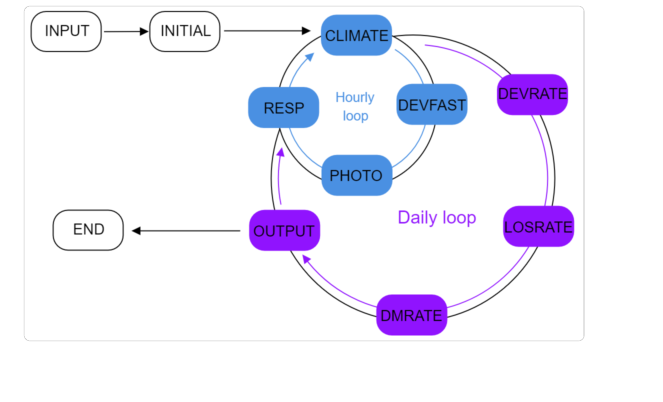

In [9]:
display(load("TomgroV2.png"))

Siguiendo el diagrama anterior, el modelo TOMGRO se descompone en las siguientes fases:
- INPUT: Lectura de datos de las condiciones iniciales del modelo.
- INITIAL:  Inicializar parámetros y variables del modelo.
- CLIMATE: Actualización de la radiación solar, la temperatura del invernadero y la humedad por hora.
- DEVFAST: Cálculo del efecto de la temperatura en la tasa de aparición de nuevos nodos $(FNT)$ y en la tasa de desarrollo de las hojas y frutas $(LDR,FDR)$.
- PHOTO: Cálculo de la fotosíntesis gruesa $(Pg)$.
- RESP: Cálculo de la respiración de mantenimiento $(Rm)$.
- DEVRATE: Cálculo de el número de nodos $(PLSTN)$, el número de racimos que dan fruto y el número de frutos por racimo. Cálculo de la etapa de desarrollo de las hojas y las frutas $(LDS, FDS)$. Cálculo de la tasa de expansión potencial de las hojas $(PLER)$, tasa de crecimiento potencial de las hojas $(PLGR)$, frutos $(PFGR)$ y tallos $(PSGR)$. Cálculo de la razón entre la oferta y demanda de $(SOSIR)$ y la respiración de crecimiento $GRESP$. 
- LOSRATE: Cálculo de la fracción de frutos "abortados" $(FABOR)$
- DMRATE: Cálculo del peso de las hojas $(DWL)$, tallos $(DWS)$ y frutos $(DWF)$ y del área de las hojas $(LA)$. Cálculo del fondo dinámico de carbón $(CPOOL)$.
- OUTPUT: Almacenamiento de los valores de las variables.

### Oferta de Carbono

Todos los cálculos son hechos por cada planta. La disponbilidad de carbohidratos para crecimiento $(CSUP,g\ dm\ d^{-1})$ es calculado al final del ciclo horario de la siguiente forma

$$CSUP = [(Pg + CPOOL - Rm)\times GREF]\times (1-PROOT)$$

donde,
- $Pg$ es la suma de la fotosíntesis gruesa diaria $(Pg, g\ CH_2 O \ d^{-1})$
- $CPOOL$ es el fondo de carbohidratos $(CPOOL,g\ CH_2 O)$
- $Rm$ es la respiración de mantenimiento $(Rm, g\ CH_2 O\ d^{-1})$
- $GREF$ es la eficiencia de crecimiento $(GREF, g\ dm\cdot g^{-1} CH_2 O)$
- $PROOT$ es la fracción de materia seca distribuida a las raíces de la planta $(PROOT, g\ dm\cdot g\ dm^{-1})$.

El modelo usado para la fotosíntesis gruesa diaria es el siguiente:
$$Pg = \frac{30\times 10^{-6}}{PLM2}\sum_{H=1}^{24}\left[\frac{P_{g,max}}{Xk} ln\left(\frac{(1-Xm)\times P_{g,max} + \epsilon\times Xk\times I}{(1-Xm)\times P_{g,max} + \epsilon\times Xk\times I \times e^{-Xk\times LAI}}\right)\times 3600  \right]$$
con,
- $P_{g,max} = \tau\times C \times PGREDT \times PGREDVPD$ es la máxima tasa de fotosíntesis de la hoja como funcipon de $C$, $T$ y $VDP$ $(P_{g,max},\mu\ mol\ CO_2 \cdot m^{-2}\cdot s^{-1})$
- $H$ es la hora del día.
- $Xk$ es el coeficiente de extinción de luz en el dosel (sin dimensión).
- $Xm$ es el cofeciente de transmisión de luz de cada hoja (sin dimensión).
- $\epsilon$ es la eficiencia de uso de la luz $(\epsilon, mol\ CO_{2} \cdot mol^{-1}\ photon)$
- $\tau$ es la eficiencia de uso del $CO_2$ $(\mu\ mol CO_2 \cdot m^{-2}\cdot s^{-1}\cdot ppm^{-1})$
- $PGREDT$ y $PGREDVPD$ son funciones (sin dimensión) que corrigen $P_{g,max}$ para temperaturas subóptimas y déficit de presión de vapor $(VPD, kPa)$
- $3600$ es el número de segundos por hora, $30$ es el peso molecular de $CH_2 O$ y $10^{-6}$ es un factor de escala de $\mu\ g$ a $g$.
- $PLM2$ es la densidad de plantas por área $(plant\cdot m^{-2})$.

# Explicación del código

## Ciclo diario

### Insertar datos horarios del clima

``` julia
    for JF in 1:NFAST

        # TFAST es la hora del día (h)
        TFAST = (JF - 1) * 24 / NFAST

        # Insertar datos horarios del clima
        d = findall(x -> x[1] == DATE && x[2] == (TFAST + 1), eachrow(RefIntClim))
        if length(d) > 1
            println("more than 1 found!!")
        end
        if isempty(d)
            println("invalid index of climate data")
        end

        d = d[1]

        
        JUL = RefIntClim[d, 1]
        IHE = RefIntClim[d, 2]
        solrad = RefIntClim[d, 3]
        TMPA = RefIntClim[d, 4]
        VPD = RefIntClim[d, 5]
        CO2L = RefIntClim[d, 6]
        PAR = solrad * TRGH
        PPFD = PAR * 4.57 
```

### Cálculo de la tasa de desarrollo 

``` julia
# Cálculo de la tasa de desarrollo 
        TEMFCF = LinearInterpolation(XTEM, GENTEM).(TMPA)
        TEMEXP1 = LinearInterpolation(TEMPLE, PLETEM).(TMPA)
        SLAMIN1 = LinearInterpolation(TEMSLA, SLAM,extrapolation_bc=Line()).(RefIntClim[d, 4])
        RDVLVF = LinearInterpolation(XLV, RDVLVT).(TMPA)
        RDVFRF = LinearInterpolation(XFR, RDVFRT).(TMPA)
```

### Cálculo de la fotosíntesis gruesa

```julia
 # Cálculo de la fotosíntesis gruesa
        GPF = 0
        # Efecto del CO2 en Pmax
        TAU2 = 0.03
        PMAX = TAU1 * CO2L
        if CO2L > 1500
            PMAX = (TAU1 * 1500) + (TAU2 * (CO2L - 1500))
        end
        PMAX *= LinearInterpolation(TMPG,PGRED)(TMPA[1])

        if PPFD >= 0.001
            if VPD >= VPDL
                # Reducción de Pmax por VPD
                PMAX *= exp(CK * (VPD - VPDL))
            end
            # Modelo de Acock
            TOP = (1 - XM) * PMAX + QE * XK * PPFD
            BOT = (1 - XM) * PMAX + QE * XK * PPFD * exp(-XK * PLAR2 * PLM2)
            GPF = (PMAX / XK) * log(TOP / BOT)
            
            GPF *= 0.682  # conversion desde CO2 a CH2O (30/44 = 0.682)
            GPF *= 3.8016 / PLM2  # conversion de GPF desde M/m2 a g/m2-día
        end
```

### Cálculo de la respiración de mantenimiento

```julia
# Cálculo de la respiración de mantenimiento
            RMAINTF = (RMRL * (TDML2 + TDMS) + RMRF * DMGF) * (Q10 ^ (0.1 * TMPA - 2.0))
```

### Integración de las variables en 24 horas

```julia
# Integración de las variables en 24 horas
            TEMFAC += TEMFCF * DTFAST
            TEMEXP += TEMEXP1 * DTFAST
            SLAMIN += SLAMIN1 * DTFAST
            RMAINT += RMAINTF * DTFAST
            RDVLV += RDVLVF * DTFAST
            RDVFR += RDVFRF * DTFAST
            GP += GPF * DTFAST
        end 
    #Finalización del ciclo horario
```

##  Desarrollo y fuerza de hundimiento

### Nodos, racimos y frutas

```julia
        # Número de nodo
        GENR = TEMFAC*LinearInterpolation(XGEN, GENRAT,extrapolation_bc=Line()).(PLSTN)
        PLSTN += GENR

        # Número de racimo
        NBRU = floor((PLSTN - FTRUSN + (1 + TPL) / TPL) * TPL / (1 + TPL))
        NBRU = max(0, NBRU)

        # Número de racimo produciendo frutas
        NBRUP = floor((PLSTN - FTRUSN - FRLG + (1 + TPL) / TPL) * TPL / (1 + TPL))
        NBRUP = max(0, NBRUP)

        # Número de hojas
        NBLV = floor(PLSTN) - NBRU

        # Número de frutas (díametro > 20mm) en cada racimo
        # Nota: FPN es ahora la razón de iniciación de fruta en un racimo por nodo de iniciación
        TRCNF = 0

        if NBRUP == 0
            NBRUP_length = -1
        else
            NBRUP_length = 1:NBRUP
        end
    
        for I in NBRUP_length
            I = Int(I)
            XX = XNFT[I]
            # FPN ahora es reemplazado por FPNPT = 0.8
            XNFT[I] = min(NBFPT[I], XNFT[I] + GENR * FPNPT)
            RCNF[I] = XNFT[I] - XX
            TRCNF += RCNF[I]
            # rncf(i) y trcnf son utilizados en el ajuste de fruta
        end
        TNF += TRCNF
```

### Fuerza de hundimiento para hojas y tallos

```julia
# Envejecimiento y fuerza de hundimiento (determinado para hojas, tallos y para cada fruta por cada unidad reproductiva)
    PTNLVS = 0
    PTNSTM = 0
    PTNFRT = 0

    # Hojas y tallos
    # nuevas hojas empiezan a envejecer cuando un nuevo racimo aparece (2 hojas abajo y 1 hoja arriba)
    for I in 1:NBRU
        I = Int(I)
        if AGLS[I] == -EPS
            PLE[I] = 0
            PGL[I] = 0
            PGS[I] = 0
        else
            # cuando se poda la hoja, no se asigna más biomasa ni a las hojas ni a los tallos de la misma unidad reproductiva
            AGLS[I] = min(1, AGLS[I] + RDVLV)
            XBOX = 100 * AGLS[I]
            # PLE(I) es el radio de expansión de hojas potencial
            # la primer unidad reproductiva tiene FTRUSN hojas, otras (1 .+ TPL)/TPL
            # 5/10/95:  remplazo de (1 .+ TPL)/TPL por 1/TPL
            if I == 1
                PLE[I] = TEMFAC * max(0, LinearInterpolation(BOX, POL)(XBOX)) * FTRUSN
            elseif I < 3
                PLE[I] = TEMFAC * max(0, LinearInterpolation(BOX, POL)(XBOX)) / TPL
            else
                PLE[I] = TEMEXP * max(0, LinearInterpolation(BOX, POL)(XBOX)) / TPL
            end
            PGL[I] = PLE[I] * (1 + FRPT) / SLAMIN
            PGS[I] = PGL[I] * FRST
        end
        PTNLVS += PGL[I]
        PTNSTM += PGS[I]
    end  # final ciclo

```

### Fuerza de hundimiento para frutas

```julia
# Fruta
        for I in 1:NBRU
            I = Int(I)
            for J in 1:floor(XNFT[I])
                J = Int(J)
                AGF[I, J] = min(1, AGF[I, J] + RDVFR)
                XBOX = 100 * AGF[I, J]
                if length(DWF[I, J]) == 0
                    PGF[I, J] = 0
                else
                    if DWF[I, J] < 0
                        PGF[I, J] = 0
                    else
                        PGF[I, J] = TEMFAC * max(0, LinearInterpolation(BOX, POF)(XBOX))
                        PTNFRT += PGF[I, J]
                    end
                end
            end
        end
```

### Otras variables de desarrollo

```julia
# Demanda de hundimiento total
        PNGP = PTNLVS + PTNSTM + PTNFRT
    #************************************************************************************************************
    #************************************************************************************************************

    # Producción diaria de biomasa
    
        RCDRW = GREF * (GP + CPOOL - RMAINT)
        if RCDRW < 0
            RCDRW = 0
            RMAINT = GP + CPOOL
        end
        RCDRW *= 1 .- LinearInterpolation(XROOT, PROOT,extrapolation_bc=Line()).(PLSTN)

    # Cálculo de la razón entre oferta y demanda
        SOSIR = min(1, RCDRW / (PNGP + EPS))

    # Respiración de crecimiento diaria
        GRESP = ((PNGP * SOSIR) / GREF) * (1 - GREF * 1.125)
        # 1.125 es (30/12)*0.45 para convertir GREF desde gDM/gCH2O a gCH2O/gCH2O 
    
    # Respiración diaria total
        TRESP = RMAINT + GRESP
```

## Ajuste de fruta

``` julia
# Ajuste de fruta
    
        TABNF = 0
        if TDMF < EPS
            dummy = 0
        else
            FABOR = min(1, (0.67 - ABORMX * SOSIR))
            FABOR = max(0, FABOR)
            TABNF = FABOR * TRCNF
        end

        TABF += TABNF
        TNSF = TNF - TABF

    # Ubicación de las frutas "abortadas": posición distal
        B = 0
        for I in 1:NBRUP
            I = Int(I)
            # Si no hay nuevos frutos, o hay menos de dos frutos en el racimo I o no hay más aborto de frutos
            if RCNF[I] == 0 || XNFT[I] <= 2 || B >= TABNF
                dummy = 0
            else
                ABNF[I] = min(4, RCNF[I], TABNF - B, XNFT[I] - 2 - ABOR[I])
                ABNF[I] = max(0, ABNF[I])
                B += ABNF[I]
                ABOR[I] += ABNF[I]
                NSF[I] = floor(XNFT[I] - ABOR[I])
                # Nótese que esto conduce a 2 frutos abortados para ABOR = 1.1
            
                if ABOR[I] < 1
                    dummy = 0
                else
                    for J in NSF[I] + 1:floor(XNFT[I])
                        J = Int(J)
                        DWF[I, J] = -EPS
                    end
                end
            end
        end
```

## Particionamiento de materia seca

```julia
# Particionamiento de materia seca
        ASCSP = 0
        TDML = 0
        TDML2 = 0
        DMGL = 0
        TDMS = 0
        TDMF = 0
        DMGF = 0
        TNMF = 0
        DMMF = 0
        PLAR = 0
        PLAR2 = 0
```

### Peso seco de hojas

```julia
for I in 1:NBRU
            I = Int(I)
            J = I + 1
            ASC = min(PGL[I], PGL[I] * SOSIR)
            ASCSP += ASC
            DWL[I] += ASC

            # Peso seco de hojas en crecimiento
            if AGLS[I] < 1
                DMGL += DWL[I]
            end

            # Ahora la expansión del área de las hojas es potencial o está limitada por un SLA máximo
            # Está disponible para cada unidad
            XLA[I] += min(PLE[I], (ASC * SLAMX / (1 + FRPT)))
            TDML += DWL[I]
        
            # Área total de hojas
            PLAR += XLA[I]
            # total menos hojas podadas (hojas podadas al cosechar el racimo)
            if AGLS[I] > 0
                PLAR2 += XLA[I]
                TDML2 += DWL[I]
            end

            #  cuando se cosecha el racimo, también se poda la mitad de las hojas superiores
            if AGLS[I] < 0
                if AGLS[J] > 0
                    PLAR2 -= XLA[J] + XLA[J]
                    TDML2 -= DWL[J] + DWL[J]
                end
            end
        end
```

### Peso seco de tallos

```julia
# Peso seco de tallos
        for I in 1:NBRU + 1
            I = Int(I)
            ASC = min(PGS[I], PGS[I] * SOSIR)
            ASCSP += ASC
            DWS[I] += ASC
            TDMS += DWS[I]
        end
```

### Peso seco de las frutas

```julia
        TDMF = 0
        ASC = 0
        for I in 1:NBRU
            I = Int(I)
            DWTR[I] = 0
            NFT = floor(XNFT[I])
            for J in 1:NFT
                J = Int(J)
                # Para fruta "abortada", DWF = -EPS
                if J == 0
                    dummy = 0
                else
                    if AGF[I, J] < 1 && DWF[I, J] >= 0
                        ASC = min(PGF[I, J], PGF[I, J] * SOSIR)
                        ASCSP += ASC
                        DWF[I, J] += ASC
                    end
                
                    if DWF[I, J] > 0
                        DWTR[I] += DWF[I, J]
                    end
                
                    # Fruta madura
                    if AGF[I, J] == 1 && DWF[I, J] > 0
                        DMMF += DWF[I, J]
                        TNMF += 1
                    end
                
                    if AGF[I, J] < 1 && DWF[I, J] > 0
                    DMGF += DWF[I, J]
                    end
                end
            end

            # Poda de las hojas (cuando se cosecha el racimo)
            # la edad de las hojas podadas se fija en -EPS para ser identificadas
            if AGF[I, Int(NBFPT[I])] >= 1
                AGLS[I] = -EPS
            end
        
        end
```

### Fondo de carbohidatos

```julia
# Fondo de carbohidatos
        CPOOL = max(0, (RCDRW - ASCSP) / GREF)

        # Cuando CPOOL es superior a un valor umbral, se limita la GP
        CPOOLMX = 0.06 * TDML / ((1 + FRPT) * GREF)

        if CPOOL > CPOOLMX
            # GP = GP - (CPOOL - CPOOLMX)
            CPOOL = CPOOLMX
        end
```

## Resultados

```julia
results[JDAY, :] = [DATE, PLSTN, NBLV, NBRU, TDML + CPOOL, TDMS, TDMF,
                        TDML + TDMS + TDMF + CPOOL, PLAR, TDML, TDML2, TDML2 + CPOOL, PLAR2,
                        PLAR2 * 10000 / ((TDML2 + CPOOL) / (1.0 + FRPT)),
                        DMMF, DMGF, TNSF, TNF - TNSF, TNMF, TDMF / (TDML + TDMS + TDMF + CPOOL),
                        GP, RMAINT, GRESP, SOSIR, CPOOL, PTNLVS, PTNSTM, PTNFRT, NBRU, NBRUP, TABNF, TNF, TNSF]
```

# Resultados

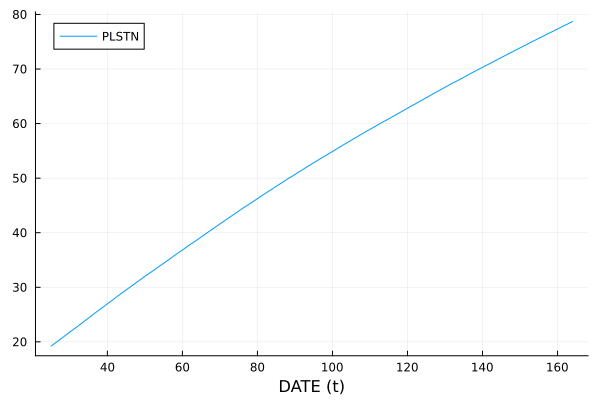

In [10]:
NombresGraficas = ["DATE","PLSTN", "NBLV", "NBRU", "TDML + CPOOL", "TDMS", "TDMF",
                "TDML + TDMS + TDMF + CPOOL", "PLAR", "TDML", "TDML2", "TDML2 + CPOOL", "PLAR2",
                "PLAR2 * 10000 / ((TDML2 + CPOOL) / (1.0 + FRPT))",
                "DMMF", "DMGF", "TNSF", "TNF - TNSF", "TNMF", "TDMF / (TDML + TDMS + TDMF + CPOOL)",
                "GP", "RMAINT", "GRESP", "SOSIR", "CPOOL", "PTNLVS", "PTNSTM", "PTNFRT", "NBRU", "NBRUP", "TABNF", "TNF", "TNSF"]

PlotsResults = [plot(results[:, 1], results[:, i], xlabel="DATE (t)", label=NombresGraficas[i]) for i in 2:33]
PlotsResults[1]

# Referencias
1. E
2. 

# Glosario

In [12]:
varinfo()

| name            |        size | summary                                        |
|:--------------- | -----------:|:---------------------------------------------- |
| ABNF            |   840 bytes | 100-element Vector{Float64}                    |
| ABOR            |   840 bytes | 100-element Vector{Float64}                    |
| ABORMX          |     8 bytes | Float64                                        |
| AGF             |   5.508 KiB | 100×7 Matrix{Float64}                          |
| AGLS            |   840 bytes | 100-element Vector{Float64}                    |
| BOX             |   136 bytes | 12-element Vector{Float64}                     |
| Base            |             | Module                                         |
| CK              |     8 bytes | Float64                                        |
| CPOOL           |     8 bytes | Float64                                        |
| Core            |             | Module                                         |
| DELT            |     8 bytes | Float64                                        |
| DMGF            |     8 bytes | Float64                                        |
| DMGL            |     8 bytes | Float64                                        |
| DTFAST          |     8 bytes | Float64                                        |
| DWF             |   5.508 KiB | 100×7 Matrix{Float64}                          |
| DWL             |   840 bytes | 100-element Vector{Float64}                    |
| DWS             |   840 bytes | 100-element Vector{Float64}                    |
| DWTR            |   840 bytes | 100-element Vector{Float64}                    |
| DatI            | 225.039 KiB | 4800×6 Matrix{Float64}                         |
| EPS             |     8 bytes | Float64                                        |
| FPNPT           |     8 bytes | Float64                                        |
| FRLG            |     8 bytes | Float64                                        |
| FRPT            |     8 bytes | Float64                                        |
| FRST            |     8 bytes | Float64                                        |
| FTRUSN          |     8 bytes | Float64                                        |
| GENRAT          |   104 bytes | 8-element Vector{Float64}                      |
| GENTEM          |    88 bytes | 6-element Vector{Float64}                      |
| GREF            |     8 bytes | Float64                                        |
| GRESP           |     8 bytes | Float64                                        |
| INTOUT          |     8 bytes | Int64                                          |
| Main            |             | Module                                         |
| NBFPT           |   840 bytes | 100-element Vector{Float64}                    |
| NDAYS           |     8 bytes | Int64                                          |
| NFAST           |     8 bytes | Int64                                          |
| NSF             |   840 bytes | 100-element Vector{Float64}                    |
| NSTART          |     8 bytes | Int64                                          |
| NombresGraficas |   833 bytes | 33-element Vector{String}                      |
| PGF             |   5.508 KiB | 100×7 Matrix{Float64}                          |
| PGL             |   840 bytes | 100-element Vector{Float64}                    |
| PGRED           |   104 bytes | 8-element Vector{Float64}                      |
| PGS             |   840 bytes | 100-element Vector{Float64}                    |
| PLAR            |     8 bytes | Float64                                        |
| PLAR2           |     8 bytes | Float64                                        |
| PLARI           |     8 bytes | Float64                                        |
| PLE             |   840 bytes | 100-element Vector{Float64}                    |
| PLETEM          |    88 bytes | 6-element Vector{Float64}                      |
| PLM2            |     8 bytes | Float64                                        |
| PLSTN           |     8 bytes | Float64                                        |
| PLSTNI          |     8 bytes | Float64                                        |
| POF             |   136 bytes | 12-element Vector{Float64}                     |
| POL             |   136 bytes | 12-element Vector{Float64}                     |
| PROOT           |    88 bytes | 6-element Vector{Float64}                      |
| PlotsResults    | 575.253 KiB | 32-element Vector{Plots.Plot{Plots.GRBackend}} |
| Q10             |     8 bytes | Float64                                        |
| QE              |     8 bytes | Float64                                        |
| RCDRW           |     8 bytes | Float64                                        |
| RCNF            |   840 bytes | 100-element Vector{Float64}                    |
| RDVFRT          |   112 bytes | 9-element Vector{Float64}                      |
| RDVLVT          |   112 bytes | 9-element Vector{Float64}                      |
| RMRF            |     8 bytes | Float64                                        |
| RMRL            |     8 bytes | Float64                                        |
| RefIntClim      | 225.039 KiB | 4800×6 Matrix{Float64}                         |
| SLAM            |    88 bytes | 6-element Vector{Float64}                      |
| SLAMX           |     8 bytes | Float64                                        |
| SOSIR           |     8 bytes | Float64                                        |
| TABF            |     8 bytes | Int64                                          |
| TAU1            |     8 bytes | Float64                                        |
| TDMF            |     8 bytes | Int64                                          |
| TDML            |     8 bytes | Float64                                        |
| TDML2           |     8 bytes | Float64                                        |
| TDMS            |     8 bytes | Float64                                        |
| TEMPLE          |    88 bytes | 6-element Vector{Float64}                      |
| TEMSLA          |    88 bytes | 6-element Vector{Float64}                      |
| TMPG            |   104 bytes | 8-element Vector{Float64}                      |
| TNF             |     8 bytes | Float64                                        |
| TNSF            |     8 bytes | Float64                                        |
| TPL             |     8 bytes | Float64                                        |
| TRESP           |     8 bytes | Float64                                        |
| TRGH            |     8 bytes | Float64                                        |
| TableC99AF1B    |   1.656 MiB | 4801-element Vector{Vector{SubString{String}}} |
| VPDL            |     8 bytes | Float64                                        |
| WLVSI           |     8 bytes | Float64                                        |
| WSTMI           |     8 bytes | Float64                                        |
| XFR             |   112 bytes | 9-element Vector{Float64}                      |
| XGEN            |   104 bytes | 8-element Vector{Float64}                      |
| XK              |     8 bytes | Float64                                        |
| XLA             |   840 bytes | 100-element Vector{Float64}                    |
| XLV             |   112 bytes | 9-element Vector{Float64}                      |
| XM              |     8 bytes | Float64                                        |
| XNFT            |   840 bytes | 100-element Vector{Float64}                    |
| XROOT           |    88 bytes | 6-element Vector{Float64}                      |
| XTEM            |    88 bytes | 6-element Vector{Float64}                      |
| plotA3          |  41.849 KiB | Plots.Plot{Plots.GRBackend}                    |
| plotA4          |  41.845 KiB | Plots.Plot{Plots.GRBackend}                    |
| plotA5          |  41.844 KiB | Plots.Plot{Plots.GRBackend}                    |
| plotA6          |  41.834 KiB | Plots.Plot{Plots.GRBackend}                    |
| results         |  36.133 KiB | 140×33 Matrix{Float64}                         |


A continuación se listan todas las variables y funciones usadas en el modelo, la lista incluye el significado, la dimensión y la manera en que se encuentran guardadas en el código.

1. `ABNF`
2. `ABOR`
3. `ABORMX`
4. `AGF`
5. `AGLS`
6. `BOX`
7. `CK`
8. `CPOOL`
9. `DELT`
10. `DMGF`
11. `DMGL`
12. `DTFAST`
13. `DWF`
14. `DWL`
15. `DWS`
16. `DWTR`